# Section 1: Exploring Data For Creating Evaluation

In [1]:
import pandas as pd
from fastparquet import ParquetFile
import duckdb

In [67]:
""" Initial Load Of Datasets We're Using """
autographs : pd.DataFrame = ParquetFile("datasets/autographs.parquet").to_pandas()
graffitis : pd.DataFrame = ParquetFile("datasets/graffiti.parquet").to_pandas()
stickers : pd.DataFrame = ParquetFile("datasets/sticker.parquet").to_pandas()
matches : pd.DataFrame = ParquetFile("datasets/matches_edit.parquet").to_pandas()
placements : pd.DataFrame = ParquetFile("datasets/placements.parquet").to_pandas()

In [ ]:
""" Fixing Tournament Dates And Names In Matches """
# query = f"""
#     SELECT 
#         strptime(regexp_replace(date, '([0-9]+)(st|nd|rd|th)', '\\1'), '%B %d %Y') AS date,
#         event,
#         "event-id",
#         winner,
#         loser,
#         "winner-score",
#         "loser-score"
#     FROM matches
# """
# df = duckdb.query(query).df()

tournament_name_map = {
    "Perfect World Shanghai Major 2024" : "Perfect World Shanghai 2024",
    "IEM Rio Major 2022"                : "IEM Rio 2022",
    "EMS One Katowice 2014"             : "2014 EMS One Katowice",
    "ESL One Cologne 2014"              : "2014 ESL One Cologne",
    "PGL CS2 Major Copenhagen 2024"     : "PGL Copenhagen 2024",
    "ESL One Katowice 2015"             : "2015 ESL One Katowice",
    "DreamHack Winter 2014"             : "2014 DreamHack Winter",
    "MLG Columbus 2016"                 : "2016 MLG Columbus",
    "PGL Major Stockholm 2021"          : "2021 PGL Stockholm",
    "StarLadder Major Berlin 2019"      : "2019 StarLadder Berlin",
    "ELEAGUE Major 2017"                : "2017 ELEAGUE Atlanta",
    "BLAST.tv Paris Major 2023"         : "BLAST.tv Paris 2023",
    "PGL Major Antwerp 2022"            : "2022 PGL Antwerp",
    "FACEIT Major 2018"                 : "2018 FACEIT London",
    "PGL Major Krakow 2017"             : "2017 PGL Krakow",
    "IEM Katowice 2019"                 : "2019 IEM Katowice",
    "DreamHack Open Cluj-Napoca 2015"   : "2015 DreamHack Cluj-Napoca",
    "ELEAGUE Major 2018"                : "2018 ELEAGUE Boston",
    "ESL One Cologne 2015"              : "2015 ESL One Cologne",
    "ESL One Cologne 2016"              : "2016 ESL One Cologne",
}

# df["event"] = df["event"].map(tournament_name_map)
placements["event"] = placements["event"].map(tournament_name_map)
placements.to_parquet("placements.parquet")

,event_id,event,team,placement
index,,,,
0,1611,2015 ESL One Katowice,fnatic,1
1,1611,2015 ESL One Katowice,Ninjas in Pyjamas,2
2,1611,2015 ESL One Katowice,Virtus.pro,3
3,1611,2015 ESL One Katowice,Envy,4
4,1611,2015 ESL One Katowice,Natus Vincere,5
...,...,...,...,...
315,7148,PGL Copenhagen 2024,HEROIC,12
316,7148,PGL Copenhagen 2024,ECSTATIC,13
317,7148,PGL Copenhagen 2024,Imperial,14


In [85]:
""" Getting Tournament With Teams """
query = f"""
    WITH
        dates AS (
            SELECT 
                matches.event,
                MIN(date) AS start_date,
                MAX(date) AS end_date,
            FROM matches
            JOIN placements ON
                matches.event = placements.event
            GROUP BY
                matches.event
        )
    SELECT dates.*, team
    FROM dates
    JOIN placements ON
        dates.event = placements.event
    ORDER BY start_date
"""

tournaments = duckdb.query(query).df()

In [128]:
""" Getting Sticker Sales During +- 15 Dates of Tournament """
query = f"""
    SELECT
        item,
        stickers.team,
        start_date,
        date,
        end_date,
        price,
        price - LAG(price, 1, 0) OVER (PARTITION BY item ORDER BY date) AS delta_price,
        volume,
        volume - LAG(volume, 1, 0) OVER (PARTITION BY item ORDER BY date) AS delta_volume,
    FROM stickers
    JOIN tournaments ON
        stickers.team = tournaments.team AND
        stickers.date >= (start_date - INTERVAL 5 DAY) AND
        stickers.date <= (end_date + INTERVAL 5 DAY)
    GROUP BY
        item, stickers.team, start_date, date, end_date, price, volume
    ORDER BY
        date, stickers.team
"""
sales = duckdb.query(query).df()
sales

,item,team,start_date,date,end_date,price,delta_price,volume,delta_volume
0,Sticker | HellRaisers (Holo) | Cologne 2014,HellRaisers,2014-08-14,2014-08-09 01:00:00,2014-08-17,1.124,1.124,466,466
1,Sticker | HellRaisers | Cologne 2014,HellRaisers,2014-08-14,2014-08-09 01:00:00,2014-08-17,0.492,0.492,2171,2171
2,Sticker | London Conspiracy (Holo) | Cologne 2014,London Conspiracy,2014-08-14,2014-08-09 01:00:00,2014-08-17,0.939,0.939,282,282
3,Sticker | London Conspiracy | Cologne 2014,London Conspiracy,2014-08-14,2014-08-09 01:00:00,2014-08-17,0.351,0.351,1336,1336
4,Sticker | Natus Vincere | Cologne 2014,Natus Vincere,2014-08-14,2014-08-09 01:00:00,2014-08-17,1.495,1.495,1438,1438
...,...,...,...,...,...,...,...,...,...
126550,Sticker | ZywOo (Glitter) | Rio 2022,Vitality,2024-12-04,2024-12-19 01:00:00,2024-12-15,0.557,0.077,1,0
126551,Sticker | apEX (Glitter) | Paris 2023,Vitality,2024-12-04,2024-12-19 01:00:00,2024-12-15,0.030,0.000,16,7
126552,Sticker | apEX (Champion) | Paris 2023,Vitality,2024-12-04,2024-12-19 01:00:00,2024-12-15,0.030,0.000,281,172
126553,Sticker | FlameZ (Glitter) | Shanghai 2024,Vitality,2024-12-04,2024-12-19 01:00:00,2024-12-15,0.030,0.000,31,-1


In [120]:
positives = placements[placements["placement"] <= 3]
negatives = placements[placements["placement"] > 3]

tournaments

,event,start_date,end_date,team
0,2014 EMS One Katowice,2014-03-13,2014-03-16,Virtus.pro
1,2014 EMS One Katowice,2014-03-13,2014-03-16,Ninjas in Pyjamas
2,2014 EMS One Katowice,2014-03-13,2014-03-16,Dignitas
3,2014 EMS One Katowice,2014-03-13,2014-03-16,LGB
4,2014 EMS One Katowice,2014-03-13,2014-03-16,fnatic
...,...,...,...,...
315,Perfect World Shanghai 2024,2024-12-04,2024-12-15,paiN
316,Perfect World Shanghai 2024,2024-12-04,2024-12-15,GamerLegion
317,Perfect World Shanghai 2024,2024-12-04,2024-12-15,3DMAX
318,Perfect World Shanghai 2024,2024-12-04,2024-12-15,BIG


# Section 2: Evaluation Framework

The goal is to predict the top 3 teams in each tournament

`Positives` -> top 3 teams per tournament

`Negatives` -> top <3 teams per tournament

In [ ]:
import numpy as np

class Eval():
    def __init__(self):
        self.matches = matches
        self.positives = placements[placements["placement"] <= 3]
        self.negatives = placements[placements["placement"] > 3]
    
    """
    Predictions should be a dictionary of [tournament] : [top 2 teams]
    """
    def metrics(self, predictions : dict[str, list[str]]):
        true_positives = 0 # Of the top 3 teams, how many we got right (Correct)
        false_positives = 0 # Of the predicted, how many were negative

        true_negatives = 0 # Of the actual positives, how many we didn't predict
        false_negatives = 0 # Of the actual negatives, how many we didn't predict (Correct)

        total = sum(len(teams) for _, teams in predictions.items())

        p_list = []
        r_list = []
        a_list = []
        tp, fp, tn, fn = 0, 0, 0, 0
        for tournament, teams in predictions.items():
            true_positives = sum(1 for k in teams if k in self.positives.loc[self.positives["event"] == tournament, "team"].tolist())
            false_positives = sum(1 for k in teams if k in self.negatives.loc[self.negatives["event"] == tournament, "team"].tolist())

            true_negatives = sum(1 for k in self.negatives.loc[self.negatives["event"] == tournament, "team"].tolist() if k not in teams)
            false_negatives = sum(1 for k in self.positives.loc[self.positives["event"] == tournament, "team"].tolist() if k in teams)

            tp += true_positives
            fp += false_positives
            tn += true_negatives
            fn += false_negatives
        
            p_list.append((true_positives) / (true_positives + false_positives + 1))
            r_list.append((true_positives) / (true_positives + false_negatives + 1))
            a_list.append((true_positives + true_negatives) / (total + 1))

        print("-=-=-=-=-=-=- Evaluation Metrics -=-=-=-=-=-=-")
        print(f"Precision: \t{np.mean(p_list):.4f}")
        print(f"Recall: \t{np.mean(r_list):.4f}")
        print(f"Accuracy: \t{np.mean(a_list):.4f}")

        return np.array([[tp, fp], [fn, tn]])

In [283]:
""" Random Classifier """
import random

class RandomModel():
    def __init__(self):
        self.name = "Random"
        self.tournaments = tournaments
        self.events = (tournaments["event"].copy()).drop_duplicates()

    def fit(self, X_train = None, y_train = None):
        pass

    def predict(self, event : str):
        teams = tournaments.loc[tournaments["event"] == event, "team"]
        teams = teams.tolist()
        
        return random.sample(teams, 3)

In [374]:
""" Heuristic Model (Volume of Sales) """
class VolumeHeuristicModel():
    def __init__(self):
        self.name = "HeuristicVolume"
        self.sales = sales
        self.tournaments = tournaments
    
    def fit(self, X_train = None, y_train = None):
        pass

    def predict(self, event: str):
        event_info = tournaments[tournaments["event"] == event]
        start_date = event_info["start_date"].drop_duplicates().values[0]
        end_date = event_info["end_date"].drop_duplicates().values[0]

        sales = self.sales

        query = f"""
            SELECT team, SUM(volume) AS total_volume
            FROM sales
            WHERE
                start_date = CAST('{start_date}' AS timestamp_ns) AND
                end_date = CAST('{end_date}' AS timestamp_ns)
            GROUP BY team
            ORDER BY total_volume DESC
            LIMIT 3
        """
        df = duckdb.query(query).df()
        return df["team"].tolist()

In [378]:
""" Approximate Money Spent Heuristic """
class MoneyHeuristicModel():
    def __init__(self):
        self.name = "MoneyHeuristic"
        self.sales = sales
        self.tournaments = tournaments
    
    def fit(self, X_train = None, y_train = None):
        pass

    def predict(self, event: str):
        event_info = self.tournaments[self.tournaments["event"] == event]
        start_date = event_info["start_date"].drop_duplicates().values[0]
        end_date = event_info["end_date"].drop_duplicates().values[0]

        sales = self.sales

        query = f"""
            SELECT team, SUM(price * volume) AS money_spent
            FROM sales
            WHERE
                start_date = CAST('{start_date}' AS timestamp_ns) AND
                end_date = CAST('{end_date}' AS timestamp_ns)
            GROUP BY team
            ORDER BY money_spent DESC
            LIMIT 3
        """

        df = duckdb.query(query).df()
        return df["team"].tolist()

In [ ]:
""" Random Forest Model """
# from sklearn.ensemble import RandomForestClassifier

class RandomForestModel():
    def __init__(self):
        self.name = "RandomForest"
        self.sales = sales
        self.tournaments = tournaments
        self.placements = placements
    
    def fit(self, X_train = None, y_train = None):
        pass

    def predict(self, event: str):
        pass

-=-=- Evaluating Random Model
-=-=-=-=-=-=- Evaluation Metrics -=-=-=-=-=-=-
Precision: 	0.1125
Recall: 	0.1367
Accuracy: 	0.1787
-=-=- Evaluating VolumeHeuristic Model
-=-=-=-=-=-=- Evaluation Metrics -=-=-=-=-=-=-
Precision: 	0.2125
Recall: 	0.2567
Accuracy: 	0.2043
-=-=- Evaluating MoneyHeuristic Model
-=-=-=-=-=-=- Evaluation Metrics -=-=-=-=-=-=-
Precision: 	0.2250
Recall: 	0.2600
Accuracy: 	0.2060


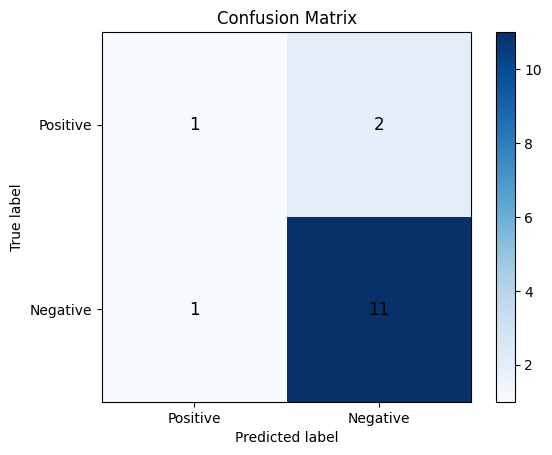

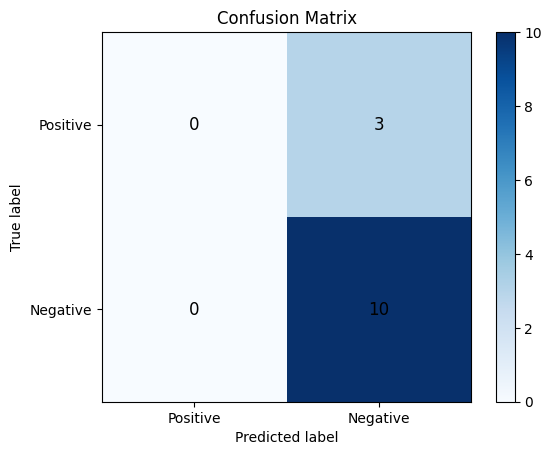

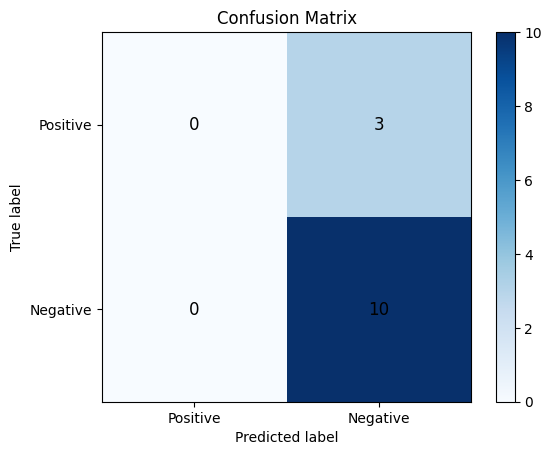

In [394]:
import matplotlib.pyplot as plt

models = {
    "Random": RandomModel(),
    "VolumeHeuristic": VolumeHeuristicModel(),
    "MoneyHeuristic": MoneyHeuristicModel()
}
eval = Eval()

for name, model in models.items():
    predictions = {}
    print(f"-=-=- Evaluating {name} Model")
    for event in tournaments["event"].copy().drop_duplicates():
        predictions[event] = model.predict(event)

    # print(predictions)
    cm = eval.metrics(predictions)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap="Blues")

    cbar = ax.figure.colorbar(im, ax=ax)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], 
                    ha="center", va="center",
                    color="black", fontsize=12)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title('Confusion Matrix')
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Positive', 'Negative'])
    ax.set_yticklabels(['Positive', 'Negative'])

plt.show()